In [2]:
from glob import glob
import pathlib
import pandas as pd
import numpy as np
import math
import re

from typing import Dict, Tuple, Type, Optional
import scipy.integrate as integrate
from polyphys.manage import organizer
from polyphys.manage.parser import SumRule
from polyphys.probe import prober
from polyphys.analyze import analyzer
from polyphys.analyze import distributions

In [12]:

# Analysis based on the dtat extracted from trajectories; in other words,\
# indirect analysis of trajectories:


def spherical_segment(
    r: float,
    a: float,
    b: float
) -> float:
    """
    computes the volume of a spherical segment.

    Parameters
    ----------
    r : float
        Radius of the sphere.
    a : float
        Distance of the first base from the center of the sphere.
    b : float
        Distance of the second base from the center of the sphere.

    Return
    ------
    vol: float
        Volume of the spherical segment.

    Notes
    -----
    1. a and b can be negative or postive, depending on the position \
    with respect to the center of sphere in the range [-r,r].
    2. When a=r or b=r, we have a spherical cap.

    References
    ----------
    https://mathworld.wolfram.com/SphericalSegment.html
    """
    if r <= 0:
        raise ValueError(
            "The radius "
            f"'{r}'"
            " is not a postive number."
        )
    # The axis, on which left, center, and right reside, points to right.
    lower = min(a, b)  # The lower bound of the volume integral
    upper = max(a, b)  # The upper bound of the volume integral
    if np.abs(upper) >= r:  # upper bound cannot larger than r.
        upper = np.sign(upper) * r
    if np.abs(lower) >= r:  # lower limit cannot less than -1*r.
        lower = np.sign(lower) * r
    vol = np.pi * (r**2 * (upper-lower) - (upper**3 - lower**3) / 3)
    # if lower and upper bounds are both outside of [-r,r] and have the
    # same signs, then vol=0:
    if lower*upper >= r**2:
        vol = 0.0
    return vol


def sphere_sphere_intersection(
        r: float,
        R: float,
        d: float
) -> float:
    """
    computes the volume of intersection of two spheres.

    The sphere with redius R is at the origin (0,0,0) while the other one \
    with radius r is located along axis x at x=d (d,0,0). This function \
    can be used to find the local volume fraction of a spherical beads \
    in the radial direction of in a space with spherical
    symmetry.

    Parameters
    ----------
    r: float
        The radius of the sphere locared along axis x.
    R: flaot
        The radius of the sphere located at the origin.
    d: float
        The distance of the the off-origin sphere from the origin along \
        axis x.

    Return
    ------
    vol: float
        The intersection volume.

    References
    ----------
    https://mathworld.wolfram.com/Sphere-SphereIntersection.html
    """
    # By define rmax and rmin, we handle the situtations in which d = 0:
    if r == 0 or R == 0:
        vol = 0.0
    else:
        rmax = max(R, r)
        rmin = min(R, r)
        if d == 0:
            # Small sphere resides completely in the large one:
            vol = 4 * np.pi * rmin ** 3 / 3
        # Spheres are either tengential to each other or do not intersect.
        elif d >= rmin + rmax:
            vol = 0.0
        # Spheres intersect:
        else:
            # Small sphere resides completely in the large one.
            if d <= rmax - rmin:
                vol = 4 * np.pi * rmin**3 / 3
            # Other scnarios:
            else:
                vol = np.pi * (rmax + rmin - d)**2 * (
                    d**2
                    + (2 * d * rmin - 3 * rmin**2)
                    + (2 * d * rmax)
                    + (6 * rmin * rmax - 3 * rmax**2) / (12*d))
    return vol


class Distribution(object):
    hist_path: str
    edge_path: str
    hist_info: Type[SumRule]
    geometry: str = 'biaxial'
    direction: str = 'longitudinal'
    normalized: bool = False
    """computes the local number density of any type of particle and the \
    local volume fraction of bead (spheres) in 1D (cylinder with the \
    periodic boundary condition (PBC) along the longitudinal axis (z axis)), \
    2D (slit with the PBC along the x and y axes (radial direction)), and 3D \
    (cube with the PBC along x, y, and z axes (spheric)).

    Parameters:
    histogram (pandas dataframe): a dataframe of an ensemble or \
    ensemble-averaged or group simulation in which the index is the bin \
    centers, the names of the columns are the name of simulations in an \
    ensemble or the name of ensemble-averaged group or the name of \
    simulation group, the columns are the frequenies of partilces of the \
    type of interest (see radius_type) in each of the bins, and the number \
    of columns is the number of simulations in a ensemble, one in an \
    ensemble-averaged group, or the number of ensmebles (=the number of \
    ensemble-averaged) groups an a simulations group.
    properties (pandas dataframe): the properties of each simulation/ \
    ensemble-averaged simulation/ensemble-averaged simulations of the \
    simualtions/ensemble-averaged simulation/ensemble-averaged simulations \
    in a ensemble/ensemble-averged group/simulation group.
    raduis_type (str): name of the column in the properties in which the size \
    (or diameter) of the particles are tabled. The particle type is the same \
    for all the particles that their frequencies are counted in histogram.
    geometry (str): the shape of the simulation box
    direction (str): the direction of interest in the geometry of interest.

    Attributes
    ----------
    self.histogram:
        histogram
    self.centers (numppy array):
        the centers of the bins: the index of histogram
    self.geometry:
        geometry
    self.direction:
        direction
    self.radius_type:
        raduis_type
    self.r_bead:
        radius of particle for whihch distribution are calculated.
    self.short_name_rho:
        the short name of number density distribution
    self.short_name_phi:
        the short name of volume fraction distribution
    self.r_bead:
        the radius of the particles that their type is set by \
        raduis_type
    self.bin_size (float):
        the size of the equaly-sized bins.
    self.edges (numpy array): the edges of the bins of the same size. The \
        range is [A-0.5*bin_size, B+0.5*bin_size]
    self.rho (pandas dataframe):
        the dataframe of the local number \
        densities which has the same index, number of columns and names of \
        columns as self.histogram. However, the column values are the local \
        number densities.
    self.phi (pandas dataframe):
        the dataframe of the local volume \
        fractions which has the same index, number of columns and names of \
        columns as self.histogram. However, the column values are the local \
        volume fractions.
    self.bounds: numpy.ndarray
        Indices of the lower and upper boundaries of a bead that resides at \
        each of centers in `self.center`.
    self.volume_shares: A two-fold nested dict
        A nested dictionary in which keys are indices of `self.centers` \
        (the positions of a bead's center) and the values are themselves \
        dictionaries. In each of this dictionary, each key is one of the \
        indices of `self.centers` within the bounds (inclusivily, i.e. \
        [A,B] includes A and B as well given by `self.bounds` and the \
        value of that key is the share of the bin of that center from the \
        volume of the bead. The sum of all the values in one inner \
        dictionary is equal to the volume of the bead.
    self._args: dict
        The arugments of eahc of the nine _integrands.

    Notes
    -----
    To calculate the distribution of local volume fraction, we have to \
    consider how the volume of a bead (particle) intersect with the bins \
    defined in a given direction in a given coordinate system. This \
    problem has two steps:
        1. Finding the bins (more precisely, the edges) by which the boundary \
        (or volume) of a particle intersects. In practice, the lower and \
        upper limits of these edges are found.
        2. Calculating the share of each bin from the volume of a bead.

    While COGs or COMs of beads can be anywhere in thesystem, it is assumed \
    that the COGs or COMs of all the beads reside in a bin are the center of \
    that bin. While this assumption produces some error in the local volume \
    distirbution, it significantly reduces the computaional cost. Moreover, the
    error decrease by increase the number of bins at a fixed volume of the \
    systen. By this assumption, all the beads in a bin are equivalent and it \
    is sufficent to do the two above steps only for one bead in a given \
    direction in a given geomtery.

    To find the upper and lower bounds on edges, the center of a bead with \
    radius `self.r_bead` is placed at one of `self.centers`. Using the \
    above assumption, for a given `self.r_bead`, a pair of lower and upper \
    bounds (`self.bounds`) can be found for each center. It is assumed \
    that a lower or upper bound is the leftmost, rightmost, innermost, or \
    outermost edges smaller than the boundary of bead in a given direction.

    There are four bin schemes:

        'concenteric':
            bins, edges, or centers are non-negative strictly increasing \
            arrays, creating concentirc circles, spherical shells, or \
            cylindircal shells along the radial direction in the polar, \
            spherical, or cylindrical coordinate system respectively.

        'consecutive':
            bins, edges, or centers are strictly increasing arrays, \
            creating consecutive slits with rectangular or circular cross \
            sections along the different directions in the cartesian \
            coordinate system or the longitudinal direction in the \
            cylindrical coordinate system respectively.

        'periodic':
            bins, edges, or centers are strictly increasing but bounded \
            by the period of the direction of interest, thus creating \
            periodic circular (or disk) sectors or spherical wedges along \
            the polar direction with period [0,2*Pi] in the polar and \
            cylindircal coordinate systems or the spherical coordiante \
            system respectively, or generating concentric.

        'neighboring:
            bins, edges, or centers are strictly increasing but bounded \
            by the period of the direction of interest, thus generating \
            sectors created by two neighboring azimuth (conic) planes \
            along the azimuth direction in the spherical coordiante system.

    For each of this bin type, an algorithm is defined below to find the
    lower and upper bounds.

    Finding bond edges along a given direction is a 1D problem. Moreover, \
    the following assumtions about positions of beads (particles), bin \
    centers and edges are used in this class:
    1. If a bead is in a bin, its position is assumed to be the center \
        of that bin, not its actual position.
    2. len(self.edges) = len(self.centers) + 1
    3. For a bin, we have: left_edge <= center < right_edge.
    4. There is only one center between two consecutive edges.
    5. The edge and center arrays are strictly increasing funcions of \
        their indices.
    6. The bins are equally spaced, son bin_size is the same between any \
        two consecutive edges.

    To coserve the total volume of the beads, the periodic boundary condition \
    (PBS) is imposed if required (For instance, the z direction in the \
    biaxial geometry). The PBC is impose in both step: finding the bounds \
    and calculating the volume shares.
    """
    _directions = {
        'box': ['r', 'theta', 'phi'],
        'slit': ['r', 'theta', 'z'],
        'biaxial': ['r', 'theta', 'z']
    }
    _integrands = {
        'box': {
            'r': lambda r, const: 4 * const * np.pi * r**2, \
            # constant is redundant and merely defined to consistantly use \
            # of 'args' parameter of "scipi.integral.quad" among integrands.
            'theta': lambda theta, dcyl: dcyl**3 / 12,
            'phi': lambda theta, dcyl: np.pi * dcyl**3 * np.sin(theta) /\
            12
        },
        'slit': {
            'r': lambda r, lcyl: 2 * np.pi * lcyl * r,
            'theta': lambda theta, lcyl, dcyl: 0.25 * lcyl * dcyl**2,
            'z': lambda z, dcyl: 0.25 * np.pi * dcyl**2
        },
        'biaxial': {
            'r': lambda r, lcyl: 2 * np.pi * lcyl * r,
            'theta': lambda theta, lcyl, dcyl: 0.25 * lcyl * dcyl**2,
            'z': lambda z, dcyl: 0.25 * np.pi * dcyl**2
        }
    }
    _fullnames = {
        'box': {
            'r': 'radial',
            'theta': 'polar',
            'phi': 'azimuthal'
        },
        'slit': {
            'r': 'radial',
            'theta': 'polar',
            'z': 'longitudinal'
        },
        'biaxial': {
            'r': 'radial',
            'theta': 'polar',
            'z': 'longitudinal'
        }
    }

    def __init__(
        self,
        hist_data: np.ndarray,
        edges: np.ndarray,
        hist_info: Type[SumRule],
        radius_attr: str,
        geometry: str = 'biaxial',
        direction: str = 'longitudinal',
        normalized: bool = False,
    ):
        if isinstance(hist_data, np.ndarray):
            self.histogram = hist_data
        else:
            raise ValueError(
                f"'{hist_data}'"
                " is not a numpy.ndarray.")
        if isinstance(edges, np.ndarray):
            self.edges = edges
            self.box_length = self.edges[-1] - self.edges[0]
            self.centers = 0.5 * (self.edges[:-1] + self.edges[1:])
            # assuming bin.edges are equally-spaced
            self.bin_size = self.edges[1] - self.edges[0]
        else:
            raise ValueError(
                f"'{edges}'"
                " is not a numpy.ndarray.")
        if geometry in self._directions.keys():
            self.geometry = geometry
        else:
            geomteries_string = (
                "'" + "', '".join(self._directions.keys()) + "'"
                )
            raise ValueError(f"'{geometry}' "
                             "is not a valid geometry for the simulation box. \
                                 Please select one of "
                             f"{geomteries_string} geometries.")
        if direction in self._directions[self.geometry]:
            self.direction = direction
        else:
            directions_string = "'" + "', '".join(
                self._directions[self.geometry]) + "'"
            raise ValueError(
                f"'{direction}' "
                "is not a valid direction for "
                f"'{self.geometry}' geometry. Please select one of "
                f"{directions_string} directions.")
        self.hist_info = hist_info
        self.r_bead = 0.5 * getattr(self.hist_info, radius_attr)
        self.normalized = normalized
        self.short_name_rho = \
            self._fullnames[self.geometry][self.direction]+'Rho'
        self.short_name_phi = \
            self._fullnames[self.geometry][self.direction]+'Phis'
        self._vol_shares_type()
        self._set_args()
        self._number_density()
        self._volume_fraction()
        if self.normalized is True:
            # the sum of rho is not equal to the bulk number density when r
            # approaches infinity, i.e. natom/vol_system. This arises from
            # the way we descritize the local number desnity.
            self.rho = self.rho / self.rho.sum()
            # time averaging: the sum of histograms = natoms * nframes.
            # normalization: the sum of the number density is now 1.
            # the sum of phi is not equal to the bulk volume fraction when r
            # approaches infinity, i.e, (natoms*vol_atom)/vol_system. This
            # arises from the way we descritize the local number desnity.
            self.phi = self.phi / self.phi.sum()

    def _consecutive_bounds(self):
        """
        finds the indices of smallest and largest bin edges by which a \
        bead, that resides at the center of that bin, intersects in a \
        'consecutive' bin scheme.

        Attributes
        ----------
        self.bounds: np.ndarray
            Indices of the leftmost and rightmost boundaries of a bead \
            that resides at each of centers in `self.center`. For each \
            each center, the following four varaibles are used to \
            generate `self.bounds`:

            leftmost:
                The value of the center of the bin in which the leftmost \
                boundary of a bead is located.

            left_bound:
                The index of the 'smaller' edge of the bin in which the \
                leftmost boundary of a bead is located.

            rightmost:
                The value of the center of the bin in which the rightmost \
                boundary of a bead is located.

            right_bound:
                The index of the 'smaller' edge of the bin in which the \
                rightmost boundary of a bead is located.
        """
        # The left- and right-most bounds by which a bead is limited:
        leftmost = self.centers - self.r_bead
        rightmost = self.centers + self.r_bead
        # Ensuring PBC to conserve total volume of all the beads:
        leftmost = np.where(
            leftmost < self.edges[0],
            leftmost + self.box_length,
            leftmost
        )
        rightmost = np.where(
            rightmost > self.edges[-1],
            rightmost - self.box_length,
            rightmost
        )
        # Initiate the leftmost with the lowest possible center index:
        left_bound = np.zeros(len(leftmost), dtype=int)
        # Initiate the rightmost with the highest possible center index:
        right_bound = (len(rightmost) - 1) * np.ones(len(rightmost), dtype=int)
        for idx, leftmost_value in enumerate(leftmost):
            for edge_idx in range(len(self.edges) - 1):
                if (leftmost_value >= self.edges[edge_idx]) and \
                        (leftmost_value < self.edges[edge_idx + 1]):
                    # left_bound is the index of the smaller edges of
                    # the leftmost bin
                    left_bound[idx] = edge_idx
                if (rightmost[idx] >= self.edges[edge_idx]) and \
                        (rightmost[idx] < self.edges[edge_idx + 1]):
                    # right_bound is the index of the smaller edges of
                    # of the rightmost bin
                    right_bound[idx] = edge_idx
        self.bounds = np.column_stack((left_bound, right_bound))

    def _consecutive_vol_shares(self):
        """
        computes the portion of the volume of a bead (a sphere) in each of \
        the consecutive disk-like bins by which the bead intersects along \
        the longitudinal direction with the PBC in a cylindrical geometry.

        To-do List
        ----------
        Vectorize the for-loops.

        Attributes
        ----------
        self.volume_shares: A two-fold nested dict
            A nested dictionary in which keys are indices of `self.centers` \
            (the positions of a bead's center) and the values are themselves \
            dictionaries. In each of this dictionary, each key is one of the \
            indices of `self.centers` within the bounds (inclusivily, i.e. \
            [A,B] includes A and B as well given by `self.bounds` and the \
            value of that key is the share of the bin of that center from the \
            volume of the bead. The sum of all the values in one inner \
            dictionary is equal to the volume of the bead.
        """
        self.volume_shares = {}
        for center_idx, bounds_minmax in enumerate(self.bounds):
            # A bead's center is the center of the bin in which it resides:
            center = self.centers[center_idx]
            self.volume_shares[center_idx] = {}
            # A bead near the end of a system along a peroidic direction
            # contributes to bins at both ends of that direction. If
            # bounds_minmax[0] > bounds_minmax[1], the BPC should be imposed:
            if bounds_minmax[0] > bounds_minmax[1]:
                # If the center is smaller than the half the box length, then
                # the bead's center is moved to the right, so the volume of
                # intersection can be calculated correctly:
                if center_idx <= len(self.centers)//2:
                    center = self.centers[center_idx] + self.box_length
                # The first element of the bounds_minmax is larger:
                for edge_idx in range(bounds_minmax[0], len(self.edges) - 1):
                    # Distacnes of a bin's left and right edges of from the
                    # center of the bead (in reality, the center of another
                    # bin):
                    left_distance = self.edges[edge_idx] - center
                    right_distance = self.edges[edge_idx + 1] - center
                    # the most right bound can be a spherical cap or
                    # segment; the `spherical_segment` is used to find
                    # the volume of intersection:
                    self.volume_shares[center_idx][edge_idx] = \
                        spherical_segment(
                            self.r_bead,
                            left_distance,
                            right_distance
                        )
                # Reset center to its inintal value to calculate the rest
                # of shares:
                center = self.centers[center_idx]
                # If the center is larger the half the box length, then
                # the bead's center is moved to the left, so the volume of
                # intersection can be calculated correctly.
                if center_idx > len(self.centers)//2:
                    center = self.centers[center_idx] - self.box_length
                for edge_idx in range(bounds_minmax[1] + 1):
                    left_distance = self.edges[edge_idx] - center
                    right_distance = self.edges[edge_idx+1] - center
                    self.volume_shares[center_idx][edge_idx] = \
                        spherical_segment(
                            self.r_bead,
                            left_distance,
                            right_distance
                        )
            # When bounds_minmax[0] <= bounds_minmax[1], everything is normalL
            else:
                for edge_idx in range(bounds_minmax[0], bounds_minmax[1] + 1):
                    left_distance = self.edges[edge_idx] - center
                    right_distance = self.edges[edge_idx+1] - center
                    self.volume_shares[center_idx][edge_idx] = \
                        spherical_segment(
                            self.r_bead,
                            left_distance,
                            right_distance
                        )

    def _concentric_bounds(self):
        """
        finds the indices of smallest and largest bin edges by which a \
        bead, that resides at the center of that bin, intersects in a \
        'concentric' bin.

        Instead of the leftmost/rightmost pairs (which are more appropriate \
        for the longitudinal direction), the innermost/outermost is used.
        """
        # The left- and right-most bounds by which a bead is limited:
        innermost = self.centers - self.r_bead
        outermost = self.centers + self.r_bead
        # Ensuring the bounds in the interval[edges[0], edges[-1]]:
        innermost = np.where(
            innermost < self.edges[0],
            self.edges[0],
            innermost
        )
        outermost = np.where(
            outermost > self.edges[-1],
            self.edges[-1],
            outermost
        )
        # Initiate the innermost bound with the lowest possible bound
        inner_bound = np.zeros(len(innermost), dtype=int)
        # Initiate the outermost bound with the highest possible bound
        outer_bound = (len(outermost) - 1) * np.ones(len(outermost), dtype=int)
        for idx, innermost_value in enumerate(innermost):
            for edge_idx in range(len(self.edges) - 1):
                if (innermost_value >= self.edges[edge_idx]) and \
                        (innermost_value < self.edges[edge_idx + 1]):
                    # inner_bound is the index of the larger edge of the
                    # innermost bin, since the intersection of the bead
                    # and that edge is important:
                    inner_bound[idx] = edge_idx + 1
                if (outermost[idx] >= self.edges[edge_idx]) and \
                        (outermost[idx] < self.edges[edge_idx + 1]):
                    # outer_bound is the index of the smaller edge of the
                    # outermost bin, since the intersection of the bead
                    # and that edge is important:
                    outer_bound[idx] = edge_idx
        self.bounds = np.column_stack((inner_bound, outer_bound))

    def _concentric_vol_shares(self):
        """
        computes the portion of the volume of a bead in each of \
        the conncentric cylindrical-shell-like or spherical-shell-like \
        bins by which the bead intersects along the radial direction in \
        a cylindrical geometry.

        To-do List
        ----------
        Vectorize the for-loops.

        Notes
        -----
        For the sake of simpilicity, the sphere-sphere interesction is \
        also used for the sphere-cylinder intersection in the radial \
        direction in the cylindrical and slit goemteries. Hence, the \
        concentric_vol_shares can be used in all these three different \
        radial directions.

        This function can be used in calculation of the local volume \
        fraction of beads in two different situation:
        1. The radial direction in the cubic geometry with the \
        sphere_sphere_intersection function as the intersection_calculator.
        2. The radial dirction in the cylindrical geometry with the \
        sphere_cylinder_intersection function as the intersection_calculator.
        """
        self.volume_shares = {}
        for center_idx, bound_minxax in enumerate(self.bounds):
            self.volume_shares[center_idx] = {}
            # The intersection volume of the previous bin; for the innermost
            # bin, there is no previous bin, so this quanyoyu is initiated
            # by 0:
            intersect_vol_previous = 0
            for edge_idx in range(bound_minxax[0], bound_minxax[1] + 2):
                # The difference between the intersection volume of a bead
                # with a bin edge with index idx and the previous bin is the
                # volume share of the bin (or center) with index idx-1:
                intersect_vol = \
                    sphere_sphere_intersection(
                        self.r_bead,
                        self.edges[edge_idx],
                        self.centers[center_idx]
                    )
                self.volume_shares[center_idx][edge_idx-1] = (
                    intersect_vol - intersect_vol_previous)
                intersect_vol_previous = intersect_vol
            # The volume share of the last bin is the difference bewteen
            # volume of the bead and the volume of the largest edges:
            self.volume_shares[center_idx][bound_minxax[1]] = (
                (4 * np.pi * self.r_bead**3) / 3 - intersect_vol_previous)

    def _vol_shares_type(self):
        """
        chooses how the volume_shares should be measured based on the \
        given direction.

        Notes
        -----
        Currently, the `_vol_shares` method is implemented in the 'radial' \
        direction in all the geometries (see the notes for \
        `_concentric_vol_shares`) and the 'longitudinal' direction in the \
        cylindrical geometry.
        """
        if self.direction == 'r':
            self._concentric_bounds()
            self._concentric_vol_shares()
        elif self.direction == 'z':
            self._consecutive_bounds()
            self._consecutive_vol_shares()
        else:
            raise ValueError(
                f"'volume_shares'"
                " is not defined in the {self.direction} direction."
                )

    def _set_args(self):
        """
        sets the arguments for the integrads along different directions \
        in different geometries.
        """
        self._args = {
            'box': {
                'r': (1, ),
                # For concentric spherical shells, the constant, i.e. 1,
                # is redundant and merely defined to make the use of args
                # parameter of scipi.integral.quad function consistent among
                # integrands.
                'theta': (0.5 * self.hist_info.lcyl, ),
                # In a box cubic or free space, the radius of the space
                # is half of the length of simulation box.
                'phi': (0.5 * self.hist_info.lcyl, ),
                # In a box cubic or free space, the radius of the space
                # is half of the length of simulation box.
            },
            'slit': {
                'r': (self.hist_info.lcyl, ),
                'theta': (self.hist_info.lcyl, self.hist_info.dcyl, ),
                'z': (self.hist_info.dcyl, )
            },
            'biaxial': {
                'r': (self.hist_info.lcyl, ),
                'theta': (self.hist_info.lcyl, self.hist_info.dcyl, ),
                'z': (self.hist_info.dcyl, )
            }
        }

    def _number_density(self):
        """
        calculates the local number density along the given direction in \
        the given geometry.

        If `self.normalized=True`, the the local number density is \
        normalized to give the area under the curve equal to one.

        Parameters
        ----------
        col_name: the name of column for which the number density is \
        calculated.

        Notes
        -----
        The number density in each simulation is an average over the number \
        densities collected every X time steps, so there are N=L/X \
        measurements of the local number desnity in each simulation where L \
        is total number of time steps in the simulation; for instance, in \
        the cylindrical sum rule project X=5000 and the total number of \
        time steps is 7*10^7, so N=14001.
        """
        integrand = self._integrands[self.geometry][self.direction]
        arguments = self._args[self.geometry][self.direction]
        bin_vols = np.array([integrate.quad(
            integrand,
            self.edges[idx],
            self.edges[idx] + self.bin_size,
            args=arguments)[0] for idx in range(len(self.edges[:-1]))
        ])
        # histogram[col_name] and bin_vols have the same size, so:
        self.rho = self.histogram / bin_vols

    def _volume_fraction(self):
        """
        computes the local volume fraction along the direction of interest \
        in the given goemetry.

        Notes
        -----
        It is assumed that all the particles have the same shape. The local \
        volume fraction is normalized to give the integral of the local \
        volume fraction  along the direction of interest in the region of \
        interest. (See the explnation for the `_number_density` method and \
        `Distribution` class).
        """
        n_centers = len(self.rho)
        self.phi = np.zeros(n_centers)
        for c_idx in range(n_centers):
            for idx, vol in self.volume_shares[c_idx].items():
                self.phi[c_idx] = self.phi[c_idx] + (self.rho[idx] * vol)


class Distribution_old():
    _geometries = ["cubic", "slit", "cylindrical"] # different types of simulation boxs: cubic (free space or pbc: periodic boundary condition in all three directions), slit (pbc in x and y directions), cylinder (pbc in z direction)
    _directions = {
        "cubic": ["radial", "polar", "azimuthal"],
        "slit": ["radial", "polar", "longitudinal"],
        "cylindrical": ["radial", "polar", "longitudinal"]
    }
    _integrands = {
        "cubic":{"radial" : lambda r, const: 4 * const * np.pi * r**2, # cocentric spherical shells; constant is redundant and merely defined to make the use of args parameter of scipi.integral.quad function consistent among integrands.
                 "polar": lambda phi, dcyl: dcyl**3 / 12, # spherical sections of diameter dcyl
                 "azimuthal": lambda theta, dcyl: np.pi * dcyl**3 * np.sin(theta) / 12 # spherical wedges of diameter dcyl
                },
        "slit":{
            "radial" : lambda r, lcyl: 2 * np.pi * lcyl * r, # cocentric cyliderical shells with length lcyl
            "polar" : lambda theta, lcyl, dcyl: 0.25 * lcyl * dcyl**2, # cylindrical sectors of length lcyl and diameter dcyl
            "longitudinal": lambda z, dcyl: 0.25 * np.pi * dcyl**2 # disks of diamter dcyl
        },
        "cylindrical":{
            "radial": lambda r, lcyl: 2 * np.pi * lcyl * r, # cocentric cyliderical shells with length lcyl
            "polar": lambda theta, lcyl, dcyl: 0.25 * lcyl * dcyl**2, # cylindrical sectors of length lcyl and diameter dcyl
            "longitudinal": lambda z, dcyl: 0.25 * np.pi * dcyl**2 # disks of diamter dcyl
        }
    }
    _short_names = {
        "cubic":{"radial" : "r",
                 "polar": "theta",
                 "azimuthal": "phi"
                },
        "slit":{
            "radial" : "r",
            "polar" : "theta",
            "longitudinal": "z"
        },
        "cylindrical":{
            "radial": "r",
            "polar": "theta",
            "longitudinal": "z"
        }
    }
    
    def __init__(self, histogram, hist_info, geometry, direction, radius_attr,normalize=True):
        if isinstance(histogram, pd.DataFrame):
            self.histogram = histogram
            self.centers = np.around(histogram.index.to_numpy(),decimals=2) # since centers are index it is important to have them round. decimals=2 work well for a_c/a<1 and a_c>a>=1 where a is monomer diamter and a_c is  crowder diamter.
        else:
            raise TypeError(f"'{histogram}' is not a Pandas Dataframe. Currently, Pandas Dataframes are only supported.")    
        if geometry in self._geometries:
            self.geometry = geometry
        else:
            geomteries_string = "'" + "', '".join(self._geometries) + "'"
            raise ValueError(f"'{geometry}'"
                             " is not a valid geometry for the simulation box. Please select one of "
                             f"{geomteries_string} geometries.")
        if direction in self._directions[self.geometry]:
            self.direction = direction
        else:
            directions_string = "'" + "', '".join(self._directions[self.geometry]) + "'"
            raise ValueError(f"'{direction}'"
                             " is not a valid direction for "
                             f"'{self.geometry}' geometry. Please select one of "
                             f"{directions_string} directions.")
        self.hist_info = hist_info
        self.r_particle = 0.5 * getattr(self.hist_info, radius_attr)
        print(self.r_particle)
        self.normalize = normalize
        self.short_name_rho = self._short_names[self.geometry][self.direction]+'Rhos'
        self.short_name_phi = self._short_names[self.geometry][self.direction]+'Phis'
        self._edges_from_centers()
        self._initiate_distribution()
        self._vol_shares_type()
        self._run()
    
    def _edges_from_centers(self):
        """
        _edges_from_centers creates bin edges from bin centers, assuming:
        1. all the bins have the same size, so the distance between two consecutive edges and two consecutive centers are equal.
        2. The centers linearly increase over range is [A,B]. ] means including B.
        
        Caution:
        len(edges) = len(centers) + 1
        """
        
        self.bin_size = np.around(self.centers[1] - self.centers[0],decimals=2) # bin_size: it shound be rounded otherwise, the bin centers (the histograms indexes) and bin edges does not have the same noumber of meaningful digits.
        self.edges = self.centers - 0.5 * self.bin_size # all the edges except the last
        self.edges = np.append(self.edges,self.centers[-1]+ 0.5*self.bin_size) # the last edge      
    
    def _initiate_distribution(self):
        """
        _initiate_distribution creates empty dataframe with the same index and columns as the given one.
    
        """
        self.rho = pd.DataFrame(index=self.histogram.index, columns=self.histogram.columns) # number density
        self.phi = pd.DataFrame(index=self.histogram.index, columns=self.histogram.columns) # local volume fraction
    
    def spherical_segment(self, r, a, b):
        """
        spherical_segment computes the volume of a spherical segment. This function is written 
        based on equation 3 in the following webpage:
        https://mathworld.wolfram.com/SphericalSegment.html

        Caution: 
        1. a and b can be negative or postive, depending on the position with respect to the center of sphere in the range [-r,r].
        2. When a=r or b=r, we have a spherical cap.

        Parameters:
        r (float): Radius of the sphere
        a (float): Distance of the first base from the center of the sphere
        b (float): Distance of the second base from the center of the sphere

        Returns:
        V (float): Volume of the spherical segment

        Requierment: 
        Numpy.
        """
        if r <= 0:
            raise ValueError(" r should be within a non-zero postive number.")
        
        lower = min(a,b) # The lower bound of the volume integral
        upper = max(a,b) # The upper bound of the volume integral
        # always upper>lower since we assume the axis over which left, center, right are located points to right.       
        if np.abs(upper) >= r :
            #print("The absolut value of the upper bound is larger r, so it is set to r.")
            upper = upper * r / np.abs(upper)
        elif np.abs(lower) >= r :
            #print("The absolute value of the lower bound is larger r, so it is set to r.")
            lower = lower * r / np.abs(lower)
        V = np.pi * (r**2*(upper-lower) - (upper**3 - lower**3)/3)
        if (np.abs(lower) >= r and np.abs(upper) >= r) and lower * upper > 0:
        #if lower * upper > r**2:
            #print(" Both a and b are either smaller than -r or larger than r.")
            V = 0
        return V

    def _consecutive_bounds(self):
        """
        _find_bounds_consecutive finds the lowest and highest bin edges by which a spherical bead residing at the center of a bin intersects. There are three types of bins: concenteric bins (and thus concentric edges) along the radial direction, consecutive bins along the longitudinal direction, and cyclic consecutive bins along the polar and azimuthal directions. This method correctly finds the bounds in the first two cases. This method find the bounds in a consecutive-bins shceme along the longitudinal direction.
        
        Cuation: 
        This is a 1D problems since the bins, bin centers and bin edges are along the same axis. In reality, the center of a spherical bead can be anywhere in a bin, but it is placed at the center of the bin along the axis of interest.
        The center of a particle can be in any of the bins, so 
        While this assumption makes the value of the local volume fraction slightly inaccurate, it singnificantly reduce the computational cost of measure the local volume fraction in a system with a large number of particles.
        The positions and r_concentrics have some relations:
        1. len(edges) = len(centers) + 1
        2. There is only one center between two consecutive edges.
        3. All the arrays are increasing funcions of their indices.
        
        leftmost/leftmost_idx is the value/index of the bin center in which the leftmost boundary of a particle is located.
        rightmost/rightmost_idx is the value/index of the bin center in which the rightmost boundary of a particle is located.
        
        Instead of the leftmost/rightmost pairs (which are more appropriate for the longitudinal direction), the innermost/outermost can also be used.
        """
        box_length = self.edges[-1] - self.edges[0] # length of simulation domain along the direction of interest.
        leftmost = self.centers - self.r_particle # The minimum distance of the r_atoms perimeter from the origin
        leftmost = np.where(leftmost < self.edges[0],leftmost + box_length,leftmost)
        leftmost_idx = np.zeros(len(leftmost),dtype=int) # Initiate the leftmost bound with the lowest possible bound
        rightmost = self.centers + self.r_particle # The maximum distance of the r_atoms perimeter from the origin
        rightmost = np.where(rightmost > self.edges[-1],rightmost - box_length,rightmost)
        rightmost_idx = (len(rightmost)-1) * np.ones(len(rightmost),dtype=int) # Initiate the rigtmost bound with the highest possible bound
        for idx, leftmost_value in enumerate(leftmost):
            for edge_idx in range(len(self.edges[:-1])):
                if (leftmost_value >= self.edges[edge_idx]) and (leftmost_value < self.edges[edge_idx+1]): # the index of the leftmost bin (or the index of the **left edges** of leftmost bin) is set as the index of the bin in which the leftmost side of the bead is located.
                    leftmost_idx[idx] = edge_idx
                if (rightmost[idx] > self.edges[edge_idx]) and (rightmost[idx] <= self.edges[edge_idx+1]): # the index of the rightmost bin (or the index of the **left edge** of rigthmost bin) is set as the index of the bin in which the rightmost side of the bead is located. Keep the difference in <= ith the leftmost in mind.
                    rightmost_idx[idx] = edge_idx
        self.particle_bounds = np.column_stack((leftmost_idx,rightmost_idx)) 

    def _consecutive_vol_shares(self): # make this method better -- see the commented effort:
        """
        _concentric_vol_shares computes the portion of the volume of a bead (a sphere) in consecutive disk-like bins along the longitudinal direction in a cylindrical geometry. The center of the test particle with radius self.r_particle is placed at the center of each bin. Depending on its radius, the particle can intersect with more than one bins. so its volume can contributes to the local volume fraction in more than one bin. In the self.volume_shares nested dictionary below,  self.centers are keys, each showing the bin at which the center of particle resides and dictionaries of the volume shares are the values. In inner dictionary, the bin center of a bin by which the particle intersects is the key and the volume of intersection of the particle with the bin is the value.
        
        In this algorithm, the total volume of a particle is conserved.

        Caution:
        The centers and edges have these relations:
        1. len(edges) = len(centers) + 1
        2. There is only one center between two consecutive edges.
        3. All the arrays are increasing funcions of their indices.
        4. To solve the problem with PBC in z direction, there is if-elif-else statement below in which the if part ensures the volume shares in the bins, that are close to the left side of the simulation box, are counted correctly and sum up to the volume of the particle. The elif part does the same for the bins close to the right side of the simulation box. the else part handles the rest of bins.

        Parameters:
        intersection_calculator: the function computes the volume of intersection between the bead with r_particle as its radius centerred at centers  and the consecute disk with diameter dcyl centered at edges. It is the self.spherical_segment in this method.

        Return: 
        volume_shares (a thwo-fold nested dict): A three-fold nested dict in which the (outmost) keys of the outmost dict are the centers and the (outmost)values of that are the dicts with an unequal number of keys. The keys of the inner dict are the edge indexes between the atom_bounds (inclusivily, i.e. [A,B] includes A and B as well) and the values of that are the volume of intersection between the bead and the bin for which the edge is the left or inner index.
        volume_shares={center1:{edge_index1: intersection_volume1, edge_index2: intersection_volume2 ...} , ...}  
        
        Effort to make this method better:
               for center_idx, bounds_minmax in enumerate(self.particle_bounds):
            self.volume_shares[center_idx] = {}
            # share of the middle bins from the volume of the sphere:
            # edge value is an increasing function of edge index
            if (bounds_minmax[0] > bounds_minmax[1]) and (center_idx <= len(self.centers)//2):
                lower_bound = bounds_minmax[0]
                upper_bound = len(self.edges)-1
                lower_bound_2 = 0
                upper_bound_2 = bounds_minmax[1]+1
                center_1 = self.centers[center_idx] + box_length # Due to the PBC, the bin center is moved to right side, so the volume of intgersection can be calculated correctly
                center_2 = self.centers[center_idx]
            elif (bounds_minmax[0] > bounds_minmax[1]) and (center_idx > len(self.centers)//2):
                lower_bound = bounds_minmax[0]
                upper_bound = len(self.edges)-1
                lower_bound_2 = 0
                upper_bound_2 = bounds_minmax[1]+1
                center_1 = self.centers[center_idx]           
                center_2 = self.centers[center_idx] - box_length # Due to the PBC, the bin center is moved to right side, so the volume of intgersection can be calculated correctly.
            else:
                lower_bound = bounds_minmax[0]
                upper_bound = bounds_minmax[1]+1
                center= self.centers[center_idx] 
            for edge_idx in range(bounds_minmax[0],bounds_minmax[1]+1,1):
                    left_distance = self.edges[edge_idx]-self.centers[center_idx]
                    right_distance =  self.edges[edge_idx+1]-self.centers[center_idx] # the most right bound can be a spherical cap or shperical segment; the spherical segments are used for the bins near the bounds of simulation box.
                    #if np.abs(right_distance) >= self.r_particle: 
                    self.volume_shares[center_idx][edge_idx] = self.spherical_segment(self.r_particle, left_distance, right_distance)
        """
        box_length = self.edges[-1] - self.edges[0]
        self.volume_shares = {}
        for center_idx, bounds_minmax in enumerate(self.particle_bounds):
            self.volume_shares[center_idx] = {}
            # share of the middle bins from the volume of the sphere:
            # edge value is an increasing function of edge index
            
            if (bounds_minmax[0] > bounds_minmax[1]) and (center_idx <= len(self.centers)//2): 
                for edge_idx in range(bounds_minmax[0],len(self.edges)-1,1):
                    center = self.centers[center_idx] + box_length # Due to the PBC, the bin center is moved to right side, so the volume of intgersection can be calculated correctly.
                    left_distance = self.edges[edge_idx] - center
                    right_distance =  self.edges[edge_idx+1] - center # the most right bound can be a spherical cap or shperical segment; the spherical segments are used for the bins near the bounds of simulation box.
                    self.volume_shares[center_idx][edge_idx] = self.spherical_segment(self.r_particle, left_distance, right_distance)
                
                for edge_idx in range(0, bounds_minmax[1]+1,1):
                    left_distance = self.edges[edge_idx] - self.centers[center_idx]
                    right_distance =  self.edges[edge_idx+1] - self.centers[center_idx] # the most right bound can be a spherical cap or shperical segment; the spherical segments are used for the bins near the bounds of simulation box.
                    self.volume_shares[center_idx][edge_idx] = self.spherical_segment(self.r_particle, left_distance, right_distance)

            elif (bounds_minmax[0] > bounds_minmax[1]) and (center_idx > len(self.centers)//2):
                for edge_idx in range(bounds_minmax[0],len(self.edges)-1,1):
                    left_distance = self.edges[edge_idx]-self.centers[center_idx]
                    #if np.abs(left_distance) >= self.r_particle: # the most left bound can be a spherical cap or a spherical segment; the spherical segments are used for the bins near the bounds of simulation box.
                    right_distance =  self.edges[edge_idx+1]-self.centers[center_idx] # the most right bound can be a spherical cap or shperical segment; the spherical segments are used for the bins near the bounds of simulation box.
                    self.volume_shares[center_idx][edge_idx] = self.spherical_segment(self.r_particle, left_distance, right_distance)
                
                for edge_idx in range(0, bounds_minmax[1]+1,1):
                    center = self.centers[center_idx] - box_length # Due to the PBC, the bin center is moved to left side, so the volume of intgersection can be calculated correctly.
                    left_distance = self.edges[edge_idx] - center
                    right_distance =  self.edges[edge_idx+1] - center # the most right bound can be a spherical cap or shperical segment; the spherical segments are used for the bins near the bounds of simulation box.
                    #if np.abs(right_distance) >= self.r_particle: 

                    self.volume_shares[center_idx][edge_idx] = self.spherical_segment(self.r_particle, left_distance, right_distance)
            
            else:
                for edge_idx in range(bounds_minmax[0],bounds_minmax[1]+1,1):
                    left_distance = self.edges[edge_idx]-self.centers[center_idx]
                    right_distance =  self.edges[edge_idx+1]-self.centers[center_idx] # the most right bound can be a spherical cap or shperical segment; the spherical segments are used for the bins near the bounds of simulation box.
                    #if np.abs(right_distance) >= self.r_particle: 
                    self.volume_shares[center_idx][edge_idx] = self.spherical_segment(self.r_particle, left_distance, right_distance)

    def sphere_sphere_intersection(self, r, R, d):
        """
        sphere_sphere_intersction computes the volume of intersection of two spheres. The sphere with redius R
        is at the origin (0,0,0) while the other one with radius r is located along axis x at x=d (d,0,0). This function can be used to find the local volume fraction of a spherical beads in the radial direction of in a space with spherical
        symmetry.

        Reference: https://mathworld.wolfram.com/Sphere-SphereIntersection.html

        Inputs:
        r: the radius of the sphere locared along axis x.
        R: the radius of the sphere located at the origin.
        d: the distance of the the off-origin sphere from the origin along axis x.

        Returns:
        V: volume of intersection.

        Requirements:
        numpy package for constant Pi.
        """
        # By define Rmax and Rmin, we handlthe situtations in which d = 0:
        Rmax = max(R,r)
        Rmin = min(R,r)
        if r ==0 or R == 0:
            V = 0 
        else : 
            if d == 0: # the small sphere resides completely in the large one.
                V = 4*np.pi*Rmin**3 / 3 

            elif d >= Rmin+Rmax: # the spheres are either tengential to eachother or not interesting.
                V = 0
            else:
                if d <= Rmax-Rmin: # the small sphere resides completely in the large one.
                    V = 4*np.pi*Rmin**3 / 3

                else :
                    V = np.pi * (Rmax + Rmin - d)**2 * (d**2 + 2*d*Rmin - 3*Rmin**2 + 2*d*Rmax + 6*Rmin*Rmax - 3*Rmax**2) / (12*d)
        return V
    
    def _concentric_bounds(self):
        """
        _find_concentric_bounds finds the lowest and highest bin edges by which a spherical bead residing at the center of a bin intersects. There are three types of bins: concenteric bins (and thus concentric edges) along the radial direction, consecutive bins along the longitudinal direction, and cyclic consecutive bins along the polar and azimuthal directions. This method correctly finds the bounds in the first two cases. This method find the bounds in a concentric-bins shceme along the  ridial direction.
        
        Cuation: 
        This is a 1D problems since the bins, bin centers and bin edges are along the same axis. In reality, the center of a spherical bead can be anywhere in a bin, but it is placed at the center of the bin along the axis of interest.
        The center of a particle can be in any of the bins, so 
        While this assumption makes the value of the local volume fraction slightly inaccurate, it singnificantly reduce the computational cost of measure the local volume fraction in a system with a large number of particles.
        The positions and r_concentrics have some relations:
        1. len(edges) = len(centers) + 1
        2. There is only one center between two consecutive edges.
        3. All the arrays are increasing funcions of their indices.
        
        Instead of the leftmost/rightmost pairs (which are more appropriate for the longitudinal direction), the innermost/outermost is used.
        """
        innermost = self.centers - self.r_particle # The minimum distance of the r_atoms perimeter from the origin
        innermost_idx = np.zeros(len(innermost),dtype=int) # Initiate the leftmost bound with the lowest possible bound
        outermost = self.centers + self.r_particle # The maximum distance of the r_atoms perimeter from the origin
        outermost_idx = (len(outermost)-1) * np.ones(len(outermost),dtype=int) # Initiate the rigtmost bound with the highest possible bound
        for idx, innermost_value in enumerate(innermost):
            for edge_idx in range(len(self.edges[:-1])):
                if (innermost_value >= self.edges[edge_idx]) and (innermost_value < self.edges[edge_idx+1]): # the inner edge index of the bin is set as the index of the bin by which the innermost side of the bead intersects.
                    innermost_idx[idx] = edge_idx + 1 # For the innermost bond, the intersection of the the bead and the outer edge of the innermost bin is important!
                if (outermost[idx] >= self.edges[edge_idx]) and (outermost[idx] < self.edges[edge_idx+1]): # the outer edge index of the bin is set as the index of the bin by which the outermost side of the bead intersects.
                    outermost_idx[idx] = edge_idx # For the outermost bond, the intersection of the the bead and the inner edge of the outermost bin is important!
        self.particle_bounds = np.column_stack((innermost_idx,outermost_idx)) 

    def _concentric_vol_shares(self):
        """
        _concentric_vol_shares computes the portion of the volume of a bead (or a sphere) in different spherical or cylindrical concenteric bins. The intersection_calculator computes the volume of intersection between the bead and the bin (sphere or cylinder) of radius r_concentric located at origin.
        For the sake of simpilicity, the sphere-sphere interesction is also used for the sphere-cylinder intersection in the radial direction in the cylindrical and slit goemteries. Hence, the concentric_vol_shares can be used in all the three different radial directions.

        Caution:
        The volume share of the innermost bin is equal to the volume of the intersection given by the intersection_calculator.
        The volume share of the other bins is equal to the volume of the intersection of the bin with the inner edge of radius r_concentric substracted by the volume of the intersection of the previous bin with the inner edge given by its radius r_concentric.

        This function can be used in calculation of the local volume fraction of beads in two different situation:
        1. The radial direction in the cubic geometry with the sphere_sphere_intersection function as the intersection_calculator.
        2. The radial dirction in the cylindrical geometry with the sphere_cylinder_intersection function as the intersection_calculator.
        
        The centers and edges have these relations:
        1. len(edges) = len(centers) + 1
        2. There is only one center between two consecutive edges.
        3. All the arrays are increasing funcions of their indices.

        Parameters:
        intersection_calculator: the function computes the volume of intersection between the bead with r_particle as its radius centerred at centers  and the concentric spherical or cylindrical shells with edges as their radii all centered at the origin. It is self.sphere_sphere_intersection for this method.

        """
        self.volume_shares = {}
        for center_idx, bound_minxax in enumerate(self.particle_bounds):
            self.volume_shares[center_idx] = {}
            intersect_vol_previous = 0 # The volume share of the lowest bin all comes from itself.
            #for edge_idx in range(bound_minxax[0]+1,bound_minxax[1]+1,1):
            for edge_idx in range(bound_minxax[0],bound_minxax[1]+2,1): # The index of upper limit is increased by 2 units since 1 units becuase of the range function and the other one is because of the share of the last outmost bin. The share of outmost bin is the volume of sphere minus the volume of the interestion of the bead with the laregest bin edge samller than the outmost edge of the bead.
                intersect_vol = self.sphere_sphere_intersection(self.r_particle, self.edges[edge_idx], self.centers[center_idx])
                self.volume_shares[center_idx][edge_idx-1]= intersect_vol - intersect_vol_previous # The intersection volume between bead and edge i belongs to bin i-1. The volume share of the previous bin i-1 should be subsracted from bin i; draw a figure to realize it!.
                intersect_vol_previous = intersect_vol # set this intersection_vol as the old one.

    def _vol_shares_type(self):
        """
        _vol_shares_type chooses how the volume_shares should be measured based on the given direction. Currently, the vol_shares method is implemented in the radial direction in all the geometries (see the notes for _concentric_vol_shares) and the longitudinal direction in the cylindrical geometry.
        """
        if self.direction == "radial":
            self._concentric_bounds()
            self._concentric_vol_shares()
        elif self.direction == "longitudinal":
            self._consecutive_bounds()
            self._consecutive_vol_shares()
        else:
            raise ValueError(f"'volume_shares' is not defined in the {self.direction} direction.")

    def _set_args(self):
        self._args = {
            "cubic": {
                "radial" : (1,), # cocentric spherical shells; constant is redundant and merely defined to make the use of args parameter of scipi.integral.quad function consistent among integrands.
                "polar": (self.hist_info.lcyl, ), # in a cubic or free space, the radius of the space is half of the length of simulation box
                 "azimuthal": (self.hist_info.lcyl, ),
            },
            "slit": {
                "radial" : (self.hist_info.lcyl, ),
                "polar" : (self.hist_info.lcyl, self.hist_info.dcyl, ),
                "longitudinal": (self.hist_info.dcyl, )
            },
            "cylindrical": {
                "radial": (self.hist_info.lcyl, ),
                "polar": (self.hist_info.lcyl, self.hist_info.dcyl,),
                "longitudinal": (self.hist_info.dcyl, )
            }
        }
    
    def _number_density(self, col_name):
        integrand = self._integrands[self.geometry][self.direction]
        arguments = self._args[self.geometry][self.direction]
        print(arguments)
        bin_vols = np.array([integrate.quad(integrand, self.edges[idx] ,self.edges[idx]+self.bin_size, args=arguments)[0] for idx in range(len(self.edges[:-1]))])
        #self.rho[col_name] = np.divide(self.histogram[col_name], bin_vols)
        self.rho[col_name] = self.histogram[col_name].divide(bin_vols) # elf.histogram[col_name] and bin_vols have the same size.
        # the sum of rho is not equal to the bulk number density (r=infiity) natom/cell_vo. This arises from the way we descritize the local number desnity.
        if self.normalize:
            self.rho[col_name] = self.rho[col_name] / self.rho[col_name].sum() # time averaging: the sum of histograms = natoms * nframes. normalization: the sum of the number density is now 1.

    def _volume_fraction(self, col_name):
        rho = self.rho[col_name].to_numpy()
        n_centers = len(rho)
        phi = np.zeros(n_centers)
        for center_idx in range(n_centers):
            for vol_share_idx, vol_share in self.volume_shares[center_idx].items():
                #phi[vol_share_idx] = phi[vol_share_idx] + (rho[center_idx] * (vol_share)) # this sum and the brelow one are equivalent.
                #phi[center_idx] = phi[center_idx] + (rho[vol_share_idx] * (vol_share))
                phi[center_idx] = phi[center_idx] + (rho[vol_share_idx] * (vol_share))
        # the sum of phi is not equal to the bulk volume fraction (r=infiity) natom*vol_per_atom/cell_vol. this arises from the way we descritize the local volume fraction and the way we relate it to the local number density.
        if self.normalize:
            self.phi[col_name] = phi / np.sum(phi)
        else:
            self.phi[col_name] = phi

    def _run(self):
        """
        _run perform a list of operation over the columns in the input histogram.
        """
        self._set_args()
        for col_name in self.histogram.columns:
            self._number_density(col_name)
            self._volume_fraction(col_name)    


## test probe bug trj segments on pc:

In [ ]:
## This approach from HERE
path = pathlib.Path('../test_data/trjs-continuous/N500D10.0ac0.8-trjs')
path = path.resolve() # convert relative path to aabsolute one
input_database = str(path)
if not pathlib.Path(input_database).exists():
    raise OSError(f"'{input_database}'"
                    "path does not exist.")
## to HERE, does not work of * is used in the string input for Path.
geometry = 'biaxial'
group = 'bug'
hierarchy = '/N*/N*'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
topologies = organizer.sort_filenames(observations, fmts=['.bug.data'])
trajectories = organizer.sort_filenames(observations, fmts=['.bug.lammpstrj'])
# 'bug' time series and historams
save_to = analyzer.database_path(input_database, phase='probe', stage='segment', group=None)
for topology in topologies:
    print(topology[0])
    topo_info = SumRule(topology[0],geometry=geometry, group=group, lineage='whole')
    save_to_whole = save_to + '/' + topo_info.whole
    save_to_whole = pathlib.Path(save_to_whole) 
    try:
        save_to_whole.mkdir(parents=True, exist_ok=False)
    except FileExistsError as error:
        print(error)
        print(
            f"Directory '{save_to_whole}'"
            " exist. Files are saved/overwritten to an existing directoy.")
    finally:
        save_to_whole = str(save_to_whole) + '/'
    for trajectory in trajectories:
        trj_info = SumRule(trajectory[0],geometry=geometry, group=group, lineage='segment')
        if trj_info.whole == topo_info.whole:
            if trj_info.segment_id ==10:
                prober.probe_bug(topology[0], trajectory[0], geometry, 'segment', save_to_whole)
            else:
                prober.probe_bug(topology[0], trajectory[0], geometry, 'segment', save_to_whole, continuous=True)

## check probe all trj segments on pc:

In [ ]:
path = pathlib.Path('../test_data/trjs-continuous/N500D10.0ac0.8-trjs')
path = path.resolve() # convert relative path to aabsolute one
input_database = str(path)
geometry = 'biaxial'
group = 'all'
hierarchy = '/N*/N*'
if not pathlib.Path(input_database).exists():
    raise OSError(f"'{input_database}'"
                    "path does not exist.")
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
topologies = organizer.sort_filenames(observations, fmts=['.all.data'])
trajectories = organizer.sort_filenames(observations, fmts=['.all.lammpstrj'])
# 'bug' time series and historams
save_to = analyzer.database_path(input_database, phase='probe', stage='segment', group=None)
for topology in topologies:
    topo_info = SumRule(topology[0],geometry=geometry, group=group, lineage='whole')
    save_to_whole = save_to + '/' + topo_info.whole
    save_to_whole = pathlib.Path(save_to_whole) 
    try:
        save_to_whole.mkdir(parents=True, exist_ok=False)
    except FileExistsError as error:
        print(error)
        print(
            f"Directory '{save_to_whole}'"
            " exist. Files are saved/overwritten to an existing directoy.")
    finally:
        save_to_whole = str(save_to_whole) + '/'
    for trajectory in trajectories:
        trj_info = SumRule(trajectory[0],geometry=geometry, group=group, lineage='segment')
        if trj_info.segment_id ==10:
            prober.probe_all(topology[0], trajectory[0], geometry, 'segment', save_to_whole)
        else:
            prober.probe_all(topology[0], trajectory[0], geometry, 'segment', save_to_whole, continuous=True)

### wholes

In [4]:
input_database = '../test_data/probe/N500D10.0ac0.8-segment'
geometry = 'biaxial'
phase = 'analysis'
stage = 'wholeSim'
group = 'bug'
hierarchy = '/N*/N*'
relation = 'tseries'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
observations = organizer.sort_filenames(observations, fmts=['bug-gyrTMon.npy'])
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
gyr_wholes = organizer.whole('gyrTMon', observations, geometry=geometry, group=group, relation=relation, save_to=save_to)

input_database = '../test_data/probe/N500D10.0ac0.8-segment'
geometry = 'biaxial'
phase = 'analysis'
stage = 'wholeSim'
group = 'all'
hierarchy = '/N*/N*'
relation = 'histogram'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
observations = organizer.sort_filenames(observations, fmts=['-all-rHistMon.npy'])
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
rhist_wholes = organizer.whole('rHistMon', observations, geometry=geometry, group=group, relation=relation, save_to=save_to)

input_database = '../test_data/probe/N500D10.0ac0.8-segment'
geometry = 'biaxial'
phase = 'analysis'
stage = 'wholeSim'
group = 'all'
hierarchy = '/N*/N*'
relation = 'bin_edge'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
observations = organizer.sort_filenames(observations, fmts=['-all-rEdgeMon.npy'])
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
redge_wholes = organizer.whole('rEdgeMon', observations, geometry=geometry, group=group, relation=relation, save_to=save_to)

[Errno 17] File exists: '../test_data/analysis/N500D10.0ac0.8-bug-wholeSim'
Directory '../test_data/analysis/N500D10.0ac0.8-bug-wholeSim' exist. Files are saved/overwritten to an existing directory.
[Errno 17] File exists: '../test_data/analysis/N500D10.0ac0.8-all-wholeSim'
Directory '../test_data/analysis/N500D10.0ac0.8-all-wholeSim' exist. Files are saved/overwritten to an existing directory.
[Errno 17] File exists: '../test_data/analysis/N500D10.0ac0.8-all-wholeSim'
Directory '../test_data/analysis/N500D10.0ac0.8-all-wholeSim' exist. Files are saved/overwritten to an existing directory.


### ensembles

In [ ]:
group = 'bug'
input_database = '../test_data/probe/N500D10.0ac0.8-segment'
phase = 'analysis'
stage = 'ens'
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
gyr_ens = organizer.ensemble(
    'gyrTMon',
    gyr_wholes,
    group=group,
    edge_wholes=None,
    save_to=save_to)
group = 'all'
input_database = '../test_data/probe/N500D10.0ac0.8-segment'
phase = 'analysis'
stage = 'ens'
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
rhist_ens = organizer.ensemble(
    'rHistMon',
    rhist_wholes,
    group=group,
    edge_wholes=redge_wholes,
    save_to=save_to)


### Ensemble averages

In [ ]:
group = 'bug'
input_database = '../test_data/probe/N500D10.0ac0.8-segment'
phase = 'analysis'
stage = 'ensAvg'
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
gyr_ens_avg = analyzer.ensemble_avg(
    'gyrTMon',
    gyr_ens,
    group=group,
    save_to=save_to)
group = 'all'
input_database = '../test_data/probe/N500D10.0ac0.8-segment'
phase = 'analysis'
stage = 'ensAvg'
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
rhist_ens_avg = analyzer.ensemble_avg(
    'rHistMon',
    rhist_ens,
    group=group,
    exclude=['bin_center'],
    save_to=save_to)

### Distributions

In [ ]:
group = 'all'
species = 'Mon'
geometry = 'biaxial'
direction = 'r'
rho, phi = distributions.distributions_generator(
    rhist_wholes,
    redge_wholes,
    group,
    species,
    geometry,
    direction)

In [ ]:
vol = 0
for value in vol_share[0].values():
    vol += value
print(vol)

In [14]:
ens = glob("../test_data/N2000*.csv")
print(ens)
print(ens[0])
rhist_crd= pd.read_csv('../test_data/N2000D20.0ac2.0nc15120.0-rHistsCrd.csv', header=0)
rhist_crd.rename(columns={"Unnamed: 0":"bin_center"}, inplace=True)
edge = np.loadtxt('../test_data/N2000epsilon5.0r10.5lz504sig2.0nc15120dt0.005bdump1000adump5000ens1-rEdges.csv')
wholes = {}
edges = {}
for col in rhist_crd.columns:
    if col!='bin_center' :
        wholes[col] = rhist_crd[col].values
        edges[col] = edge

['../test_data/N2000D20.0ac2.0nc15120.0-rPhisMon.csv', '../test_data/N2000D20.0ac2.0nc15120.0-rRhosMon.csv', '../test_data/N2000D20.0ac2.0nc15120.0-rHistsCrd.csv', '../test_data/N2000D20.0ac2.0nc15120.0-rRhosCrd.csv', '../test_data/N2000D20.0ac2.0nc15120.0-rHistsMon.csv', '../test_data/N2000D20.0ac2.0nc15120.0-rPhisCrd.csv', '../test_data/N2000epsilon5.0r10.5lz504sig2.0nc15120dt0.005bdump1000adump5000ens1-rEdges.csv']
../test_data/N2000D20.0ac2.0nc15120.0-rPhisMon.csv


In [ ]:
rhist_crd

In [16]:
#rhist_crd = rhist_crd.set_index('bin_center')
hist_info  = SumRule(rhist_crd.columns[0],geometry='biaxial', group='all', lineage='whole')
print(hist_info.lineage_name)
dist = Distribution_old(
    rhist_crd,
    hist_info,
    'cylindrical',
    'longitudinal',
    'dcrowd',
    normalize=False)

N2000epsilon5.0r10.5lz504sig2.0nc15120dt0.005bdump1000adump5000ens1
1.0
(20.0,)
(20.0,)
(20.0,)
(20.0,)
(20.0,)
(20.0,)
(20.0,)
(20.0,)


<AxesSubplot:xlabel='bin_center'>

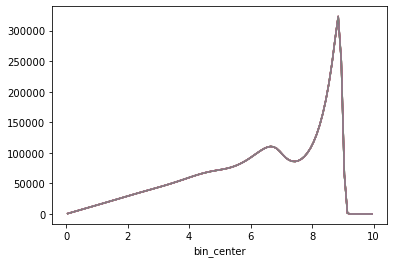

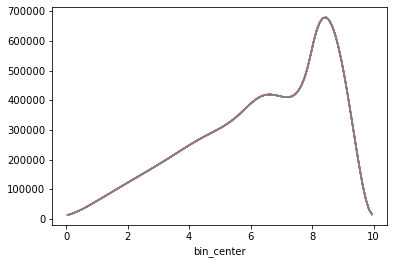

In [17]:
dist.rho.plot(legend=False)
dist.phi.plot(legend=False)

In [ ]:
group = 'all'
species = 'Crd'
geometry = 'biaxial'
direction = 'r'
rho, phi = distributions.distributions_generator(
    wholes,
    edges,
    group,
    species,
    geometry,
    direction,
    normalized=False)

In [ ]:
rho_df = pd.DataFrame(rho)
rho_df.plot(legend=False)

In [ ]:
phi_df = pd.DataFrame(phi)
phi_df.plot(legend=False)

['../test_data/N2000D20.0ac2.0nc15120.0-rPhisMon.csv', '../test_data/N2000D20.0ac2.0nc15120.0-rRhosMon.csv', '../test_data/N2000D20.0ac2.0nc15120.0-rHistsCrd.csv', '../test_data/N2000D20.0ac2.0nc15120.0-rRhosCrd.csv', '../test_data/N2000D20.0ac2.0nc15120.0-rHistsMon.csv', '../test_data/N2000D20.0ac2.0nc15120.0-rPhisCrd.csv', '../test_data/N2000epsilon5.0r10.5lz504sig2.0nc15120dt0.005bdump1000adump5000ens1-rEdges.csv']
../test_data/N2000D20.0ac2.0nc15120.0-rPhisMon.csv


<AxesSubplot:>

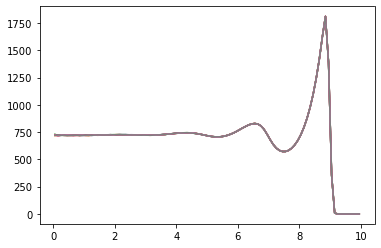

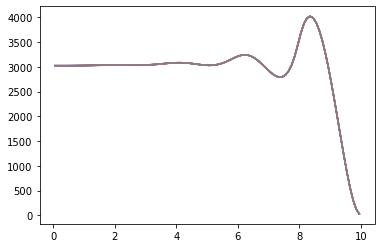

In [18]:
ens = glob("../test_data/N2000*.csv")
print(ens)
print(ens[0])
rrho_crd= pd.read_csv('../test_data/N2000D20.0ac2.0nc15120.0-rRhosCrd.csv', header=0, index_col=0)
rrho_crd.plot(legend=False)
rphi_crd= pd.read_csv('../test_data/N2000D20.0ac2.0nc15120.0-rPhisCrd.csv', header=0, index_col=0)
rphi_crd.plot(legend=False)

### whole_from_Segments

In [ ]:
input_database = '../test_data/probe/N500D10.0ac0.8-segment'
geometry = 'biaxial'
hierarchy = '/N*/N*'
lineage = 'segment'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
#save_to = analyzer.database_path(input_database, phase='analysis', stage='wholeSim', group=group)
analyzer.analyze_segments(input_database, geometry, hierarchy)

In [ ]:
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=4)
client

### This script is used in GNU-Parallel

In [ ]:
from glob import glob
from PipeLine import *

fname = glob("../N*.bug.*")
fname = PipeLine.file_reader(fname) # This is a list with one member

save_to="./"
geom = 'cylindrical'
print(fname)
PipeLine.extract_trj_bug(fname[0], geom, save_to) # A list with one member, the member is a tuple of a trj and data pair.
#PipeLine.bug_trj_rmsd(fname[0], geom, save_to) 

trj_files = glob("./N*all.lammpstrj")
all_tuples = PipeLine.file_reader(trj_files,extensions=['lammpstrj'])
all_trjs = [all_tuple[0] for all_tuple in all_tuples]

data_file = glob("./N*.all.data")
all_data = PipeLine.file_reader(data_file,extensions=['all.data'])
all_data = all_data[0][0]

    
for all_trj in all_trjs:
    print(all_trj)
    PipeLine.extract_trj_all(all_data, all_trj, geom, save_to)

## Standard approach: Running on clusters: extraction from orgaznied *trjs_all* and *trjs_bug* directories

### This are not work properly on Graham cluster but work well on iMacmini

### 1. Extract from an organized *trjs_bug* directory:

In [ ]:
# This script extract different bug's information from pairs (toplogy and trajectory) of bug simulation files in oen or more organized *trjs_bug* directories.
from pathlib import Path
import os
from glob import glob
from PipeLine import *
from dask.distributed import Client
from dask import delayed
from dask import compute

cores = 32
print(f"number of workers set to {cores}; is this the same requested cores on the cluster?")
client = Client(n_workers=cores)
home = str(Path.home())
cwdir = str(Path.cwd())
# information extraction from simulations
geom = 'cylindrical'
fname = glob(home+'/amirhsi_rrg/cylinder_simulations/N*-trjs_bug/N*bug*')
bug_pairs = PipeLine.file_reader(fname) # each bug_pair is a pair of trajectory and topopgy file.
trjs_computed = []
bug_dir = 'extraction_bug/'
for bug_pair in bug_pairs:
    sim_name = bug_pair[0].split("/")[-1].split('bug')[0]
    sim_dir = cwdir+bug_dir+sim_name
    Path(sim_dir).mkdir(parents=True, exist_ok=False)
    sim_save_to = sim_dir+"/"
    trj_delayed = delayed(PipeLine.extract_trj_bug)(bug_pair, geom,sim_save_to)
    trjs_computed.append(trj_delayed)
results = compute(trjs_computed)

### 2. Extract from an organized *trjs_all* directory:

In [ ]:
# This script extract different bug's information from pairs (toplogy and trajectory) of bug simulation files in oen or more organized *trjs_bug* directories.
from pathlib import Path
import os
from glob import glob
from PipeLine import *
from dask.distributed import Client
from dask import delayed
from dask import compute

cores = 32
print(f"number of workers set to {cores}; is this the same requested cores on the cluster?")
client = Client(n_workers=cores)
home = str(Path.home())
cwdir = str(Path.cwd())
sim_all_dirs = glob(home+'/amirhsi_rrg/cylinder_simulations/N*-trjs_all/N*/')
geom = 'cylindrical'

trjs_computed = []
all_extraction_dir = 'extraction_all/'
for sim_all_dir in sim_all_dirs:
    sim_name = sim_all_dir[0].split("/")[-1]
    all_trjs = glob(sim_all_dir+"N*.lammpstrj")
    all_trjs = PipeLine.file_reader(all_trjs,extensions=['lammpstrj'])
    all_trjs = [all_trj[0] for all_trj in all_trjs]

    all_topology = glob(sim_all_dir+"N*.all.data")
    all_topology = PipeLine.file_reader(all_topology,extensions=['all.data'])
    all_topology = all_topology[0][0]
    
    
    sim_extract_dir = cwdir+all_extraction_dir+sim_name
    Path(sim_extract_dir).mkdir(parents=True, exist_ok=False)
    sim_save_to = sim_extract_dir+"/"
    
    for all_trj in all_trjs:
        trj_delayed = delayed(PipeLine.extract_trj_all)(all_topology, all_trj, geom,sim_save_To)
        trjs_computed.append(trj_delayed)

results = compute(trjs_computed)

## Extraction from *extraction_bug* directory after a simulation

In [ ]:
home = str(Path.home())
path=home+'N2000epsilon5.0r10.5lz336sig1.0nc100800dt0.005bdump1000adump5000ens1'
fname = glob(path+"/N*.bug.*")
fname = PipeLine.file_reader(fname) # This is a list with one member
geom = 'cylindrical'
print(fname)
PipeLine.extract_trj_bug(fname[0], geom) # A list with one member, the member is a tuple of a trj and data pair.
PipeLine.rmsd_trj_bug(fname[0], geom)

In [ ]:
# all the segments in one trajectory: M dump files + one data file.
path='/Users/amirhsi_mini/N2000epsilon5.0r10.5lz336sig1.0nc100800dt0.005bdump1000adump5000ens*'
geom = 'cylindrical'
trj_files = glob(path+"/N*.lammpstrj")
all_tuples = PipeLine.file_reader(trj_files,extensions=['lammpstrj',])
all_trjs = [all_tuple[0] for all_tuple in all_tuples]
data_file = glob(path+"/N*.all.data")
all_data = PipeLine.file_reader(data_file,extensions=['all.data'])
all_data = all_data[0][0]
for all_trj in all_trjs:
    PipeLine.extract_trj_all(all_data, all_trj, geom)

## New approach: tested on iMac Pro:

### A single ensemble with one or more segments with one data file

In [ ]:
path='/Users/amirhsi_mini/N2000epsilon5.0r15.5lz379.5sig6.0nc1068dt0.005bdump1000adump5000ens*'
#path='/Users/amirhsi_mini/N1000epsilon5.0r8.0lz308.5sig2.0nc10412dt0.005bdump1000adump5000ens*'
geom = 'cylindrical'
trj_files = glob(path+"/N*all*")
all_pairs = PipeLine.file_reader(trj_files)
trjs_computed = []
for all_pair in all_pairs:
    trj_delayed = delayed(PipeLine.extract_all_trj_polymer_cog_fsd)(all_pair[1], all_pair[0], geom)
    trjs_computed.append(trj_delayed)

In [ ]:
%%time
results = compute(trjs_computed)

### N ensemble with N data file, each ensemble with one or more segments 

In [ ]:
path='/Users/amirhsi_mini/N2000epsilon5.0r15.5lz379.5sig6.0nc1068dt0.005bdump1000adump5000ens*'
#path='/Users/amirhsi_mini/N1000epsilon5.0r8.0lz308.5sig2.0nc10412dt0.005bdump1000adump5000ens*'
geom = 'cylindrical'
trj_pathes = glob(path+"/N*all*")
trjs = PipeLine.file_reader(trj_pathes,extensions=['lammpstrj'])
trjs = [trj[0] for trj in trjs]
topology_pathes = glob(path+"/N*.all.data")
topologies = PipeLine.file_reader(topology_pathes,extensions=['all.data'])
topologies = [topology[0] for topology in topologies]

In [ ]:
def simulation(pair):
    """
    simulation_pair pairs an "all" topology file with all the "all" trjectories of that "all" topology.
    
    Parameters:
    pair (list of tuples): a list in whic each tuple is  pair of topolgy and trajectories of a simulations.
    
    Return:
    a dict of of simulation pairs.
    """
    return {'topology':pair[0], 'trajectories':pair[1]}

In [ ]:
ens_names = [topology.split("/")[-1].split('.all')[0] for topology in topologies]
ens_names = list(dict.fromkeys(ens_names))
trjs_per_ens = []
for ens_name in ens_names:
    ens_trjs = []
    for trj in trjs:
        trj_name = trj.split("/")[-1].split(".all")[0]
        if trj_name == ens_name:
            ens_trjs.append(trj)
            #ensembles[key]['trajectories'] = trj
    trjs_per_ens.append(ens_trjs)
ensembles= dict(zip(ens_names,list(map(simulation,list(zip(topologies,trjs_per_ens))))))

In [ ]:
geom = 'cylindrical'
trjs_computed = []
for ensemble in ensembles.values():
    for trj_segment in ensemble['trajectories']:
        trj_delayed = delayed(PipeLine.extract_trj_all)(ensemble['topology'], trj_segment, geom)
        trjs_computed.append(trj_delayed)

In [ ]:
%%time
results = compute(trjs_computed)